In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from __prepare_hydrometeors import calc_bulkRhoRime

plt.rcParams.update({'font.size':16})

#data = xr.open_dataset('good_fwdP3.nc')
data = xr.open_dataset('fwdP3.nc')

/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


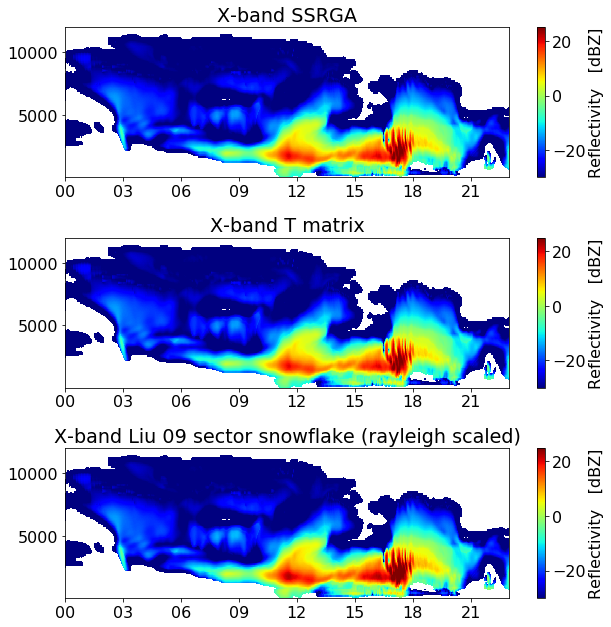

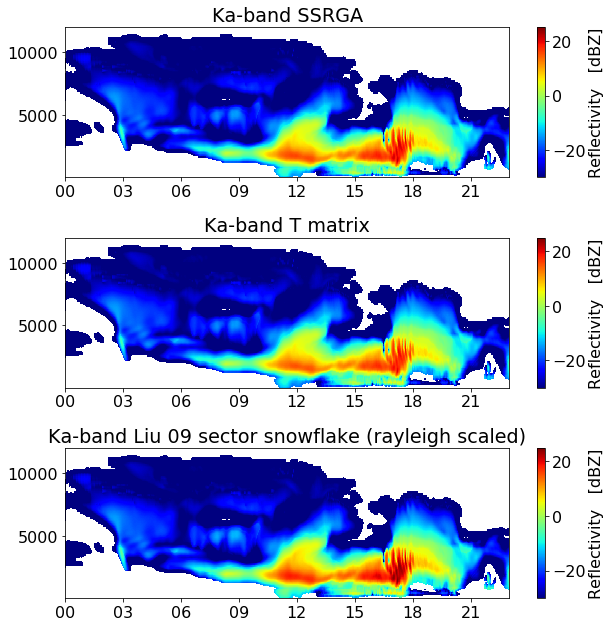

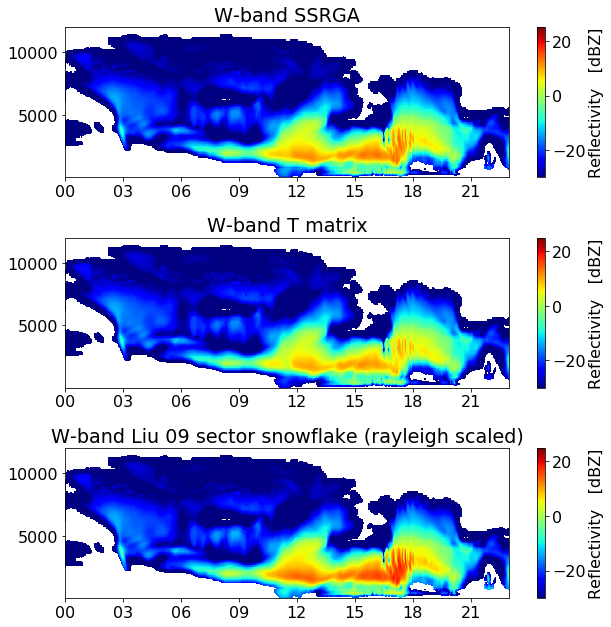

In [2]:
freq = 'Ka'
for freq in ['X', 'Ka', 'W']:
    fig, axs = plt.subplots(3, 1, figsize=(9, 9))
    mesh = axs[0].pcolormesh(data.time, data.height, data.Zssrga.loc[dict(frequency=freq)].T, vmin=-30, vmax=25, cmap='jet')
    axs[0].set_title(freq + '-band SSRGA')
    cbar = plt.colorbar(mesh, ax=axs[0])
    cbar.set_label('Reflectivity   [dBZ]')
    mesh = axs[1].pcolormesh(data.time, data.height, data.Ztm.loc[dict(frequency=freq)].T, vmin=-30, vmax=25, cmap='jet')
    cbar = plt.colorbar(mesh, ax=axs[1])
    cbar.set_label('Reflectivity   [dBZ]')
    axs[1].set_title(freq + '-band T matrix')
    mesh = axs[2].pcolormesh(data.time, data.height, data.Zliu09.loc[dict(frequency=freq)].T, vmin=-30, vmax=25, cmap='jet')
    cbar = plt.colorbar(mesh, ax=axs[2])
    cbar.set_label('Reflectivity   [dBZ]')
    axs[2].set_title(freq + '-band Liu 09 sector snowflake (rayleigh scaled)')
    [a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
    fig.tight_layout()
    fig.savefig('iceSSRGA_TM_Liu_'+freq+'.png')
    #fig.savefig('iceSSRGA_TM_Liu_'+freq+'.pdf')

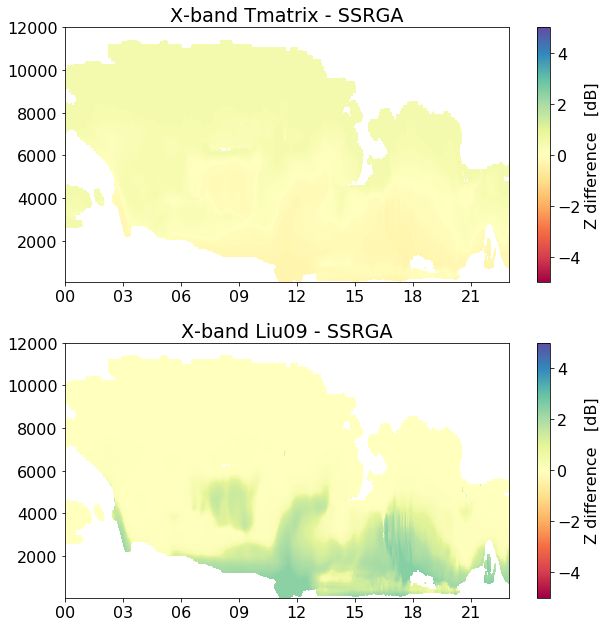

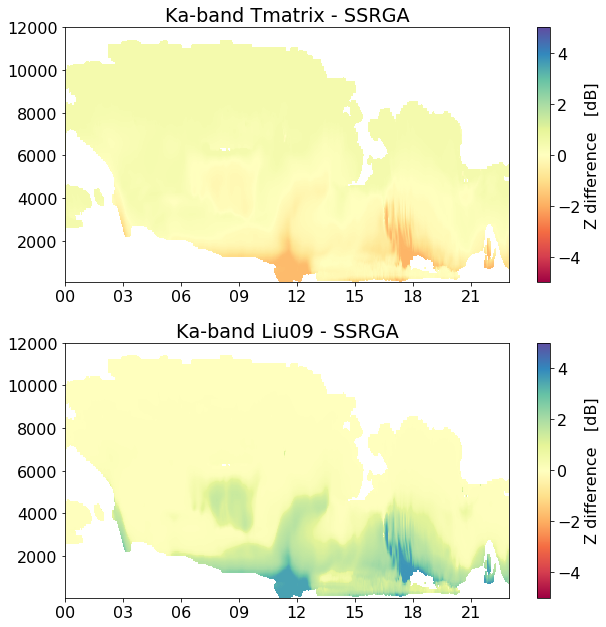

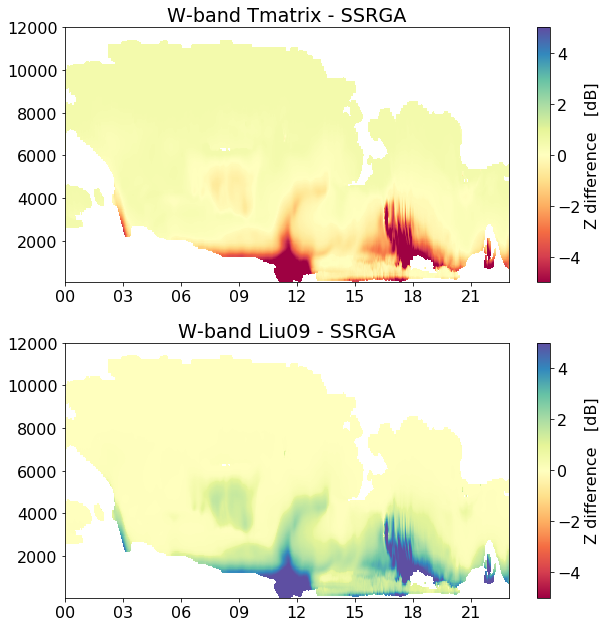

In [3]:
for freq in ['X', 'Ka', 'W']:
    fig, axs = plt.subplots(2, 1, figsize=(9, 9))
    mesh = axs[0].pcolormesh(data.time, data.height, data.Ztm.loc[dict(frequency=freq)].T-data.Zssrga.loc[dict(frequency=freq)].T, vmin=-5, vmax=5, cmap='Spectral')
    cbar = plt.colorbar(mesh, ax=axs[0])
    cbar.set_label('Z difference   [dB]')
    axs[0].set_title(freq + '-band Tmatrix - SSRGA')
    mesh = axs[1].pcolormesh(data.time, data.height, data.Zliu09.loc[dict(frequency=freq)].T-data.Zssrga.loc[dict(frequency=freq)].T, vmin=-5, vmax=5, cmap='Spectral')
    cbar = plt.colorbar(mesh, ax=axs[1])
    cbar.set_label('Z difference   [dB]')
    axs[1].set_title(freq + '-band Liu09 - SSRGA')
    [a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
    fig.tight_layout()
    fig.savefig('TmLiu-SSRGA'+freq+'.png')
    #fig.savefig('TmLiu-SSRGA'+freq+'.pdf')

In [4]:
dcrits = data.dcrits.values
dcrits[(dcrits==0.0)+(dcrits>1)] = np.nan

In [5]:
iconP3path = '/data/optimice/P3paper_ICONoutput/P3realcase__20151124_624m_satad0/hlev_int50m_basic__DOM01_ML_20151124T*Z.nc'
iconP3files = sorted(glob(iconP3path))

# Keep only the important variables
drops = ['u', 'v', 'w',
         #'temp',
         't_g', 'u_10m', 'v_10m',
         'qv', 'clc',
         #'qc', 'qi', 'qr', 'qirim', 'birim', 'qnc', 'qnr', 'qni',
         'p3eqv_refl', # keeping for comparison purposes
         'p3reff_cld', 'p3reff_ice', 'p3mw_vi', 'p3dmean_ice', 
         #'p3rho_ice', # see if I can make use of it
         'p3ncnuc', 'p3qcnuc', 'p3ncheti', 'p3qcheti', 'p3nrheti', 'p3qrheti', 'p3ninuc', 'p3qinuc',
         'qccondiag', 'qrcondiag', 'dep_rate_ice', 'aggr_ice_n', 't_cbase', 'p_cbase', 't_ctop', 'p_ctop',
         #'rh',
         'temp_old',
         #'pres',
         # 'lamc', 'lamr', 'lami', 'mu_c', 'mu_r' # these Markus calculate himself, why?
        ]
# markusToKeep=["temp","pres","rh","qc","qi","qr","qnc","qni","qnr","qirim","birim"]

# Preprocessing of the data
def generate_preprocess(): # can take arguments
    # Generate a preprocess function that takes a dataset as only argument and does all the processing needed
    def preprocess(ds):
        # Convert strage YMD.fraction_of_the_day format into datetime64 (loss precision not important)
        ds['time'] = pd.to_datetime(ds.time.values.astype(int).astype(str), format='%Y%m%d') + pd.to_timedelta(ds.time.values%1, unit='D').round('1s')
        return ds
    return preprocess
iconP3data = xr.open_mfdataset(iconP3files,
                               concat_dim='time',
                               data_vars='minimal',
                               preprocess=generate_preprocess(), # drop_variables is called first
                               drop_variables=drops
                              ).isel(lat=0, lon=0).squeeze()
qi_tot = iconP3data.qi + iconP3data.qirim
rime_fraction = iconP3data.qirim/qi_tot.fillna(0.0)
vector_bulkRhoRime = np.vectorize(calc_bulkRhoRime)
rime_density = vector_bulkRhoRime(iconP3data.qirim, iconP3data.birim)

<ipython-input-5-e63d5ed88fc2>:30: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  iconP3data = xr.open_mfdataset(iconP3files,
/usr/lib/python3/dist-packages/xarray/backends/api.py:934: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` f

/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


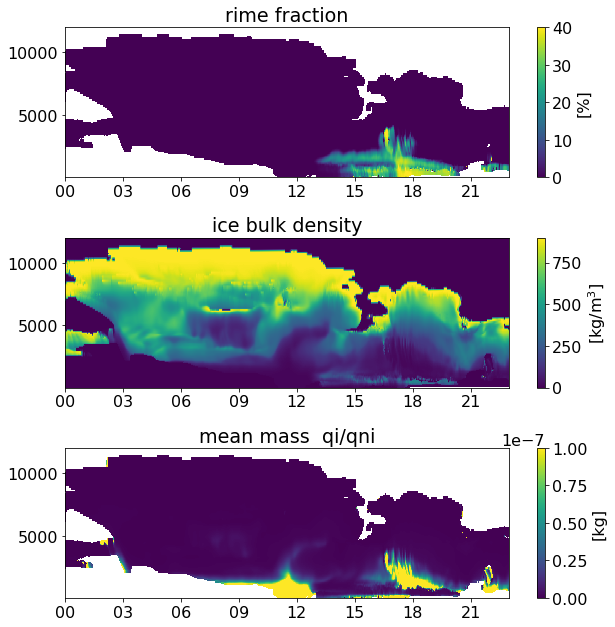

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(9, 9))
mesh = axs[0].pcolormesh(data.time, data.height, 100*rime_fraction.T, vmax=40)
cbar = plt.colorbar(mesh, ax=axs[0])
axs[0].set_title('rime fraction')
cbar.set_label('[%]')
mesh = axs[1].pcolormesh(data.time, data.height, iconP3data.p3rho_ice.T)
cbar = plt.colorbar(mesh, ax=axs[1])
axs[1].set_title('ice bulk density')
cbar.set_label('[kg/m$^3$]')
mesh = axs[2].pcolormesh(data.time, data.height, iconP3data.qi.T/iconP3data.qni.T, vmax=1.0e-7)
cbar = plt.colorbar(mesh, ax=axs[2])
axs[2].set_title('mean mass  qi/qni')
cbar.set_label('[kg]')
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
fig.tight_layout()
fig.savefig('microphysical_properties.png')

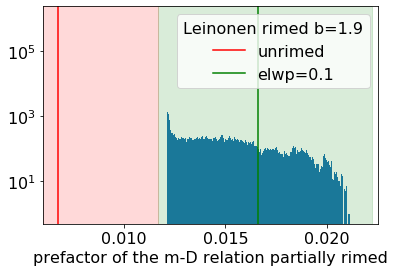

In [7]:
elwps = [0.0, 0.1, 0.2, 0.5]
coefs = [0.0067659, 0.0166, 0.0278, 0.0692]


plt.figure()
a = plt.hist(data.csr.values[(data.csr>0)*(data.csr<23)].flatten(), bins=1000)
np.nanmax(data.csr.values[(data.csr>0)*(data.csr<23)])
len(data.csr.values[(data.csr>0)*(data.csr<23)])
plt.axvspan(0.006, 0.5*(coefs[0]+coefs[1]), alpha=0.15, color='red')
plt.axvspan(0.5*(coefs[0]+coefs[1]), 0.5*(coefs[1]+coefs[2]), alpha=0.15, color='green')
#plt.axvspan(0.5*(coefs[1]+coefs[2]), 0.5*(coefs[2]+coefs[3]), alpha=0.25, color='red')
plt.axvline(coefs[0], color='red', label='unrimed')
plt.axvline(coefs[1], color='green', label='elwp=0.1')
plt.yscale('log')
plt.legend(title='Leinonen rimed b=1.9')
plt.xlim([0.006, 0.0225])
plt.xlabel('prefactor of the m-D relation partially rimed')
plt.savefig('csr_fixed_b19.png')
plt.savefig('csr_fixed_b19.pdf')

33.48503828048706


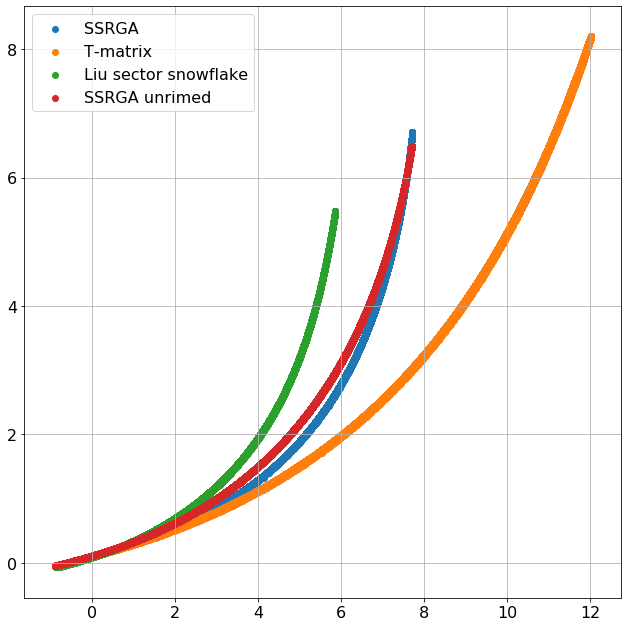

In [8]:
radar = xr.open_dataset('/data/optimice/tripex/tripex_level_02_test/tripex_joy_tricr00_l2_any_v00_20151124000000.nc')
import time
start = time.time()
fig, axs = plt.subplots(1, 1, figsize=(9, 9))
freq = 'Ka'
ssrgaXKa = (data.Zssrga.loc[dict(frequency='X')]-data.Zssrga.loc[dict(frequency='Ka')]).values.flatten()
tmXKa = (data.Ztm.loc[dict(frequency='X')]-data.Ztm.loc[dict(frequency='Ka')]).values.flatten()
liu09XKa = (data.Zliu09.loc[dict(frequency='X')]-data.Zliu09.loc[dict(frequency='Ka')]).values.flatten()
ssrgaKaW = (data.Zssrga.loc[dict(frequency='Ka')]-data.Zssrga.loc[dict(frequency='W')]).values.flatten()
tmKaW = (data.Ztm.loc[dict(frequency='Ka')]-data.Ztm.loc[dict(frequency='W')]).values.flatten()
liu09KaW = (data.Zliu09.loc[dict(frequency='Ka')]-data.Zliu09.loc[dict(frequency='W')]).values.flatten()

axs.scatter(ssrgaKaW, ssrgaXKa, label='SSRGA')#, c=meanMass)
axs.scatter(tmKaW, tmXKa, label='T-matrix')#, c=meanMass)
axs.scatter(liu09KaW, liu09XKa, label='Liu sector snowflake')#, c=meanMass)

dato = xr.open_dataset('good_fwdP3.nc')
ssrgoXKa = (dato.Zssrga.loc[dict(frequency='X')]-dato.Zssrga.loc[dict(frequency='Ka')]).values.flatten()
ssrgoKaW = (dato.Zssrga.loc[dict(frequency='Ka')]-dato.Zssrga.loc[dict(frequency='W')]).values.flatten()
axs.scatter(ssrgoKaW, ssrgoXKa, label='SSRGA unrimed')#, c=meanMass)

axs.legend()
axs.grid()
fig.tight_layout()
fig.savefig('triple_frequency.png')
print(time.time() - start)

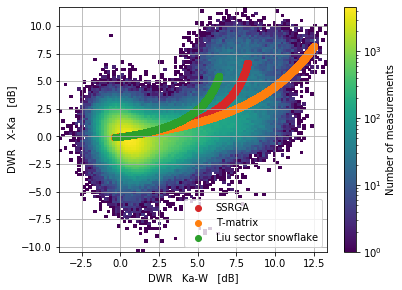

In [16]:
radar = xr.open_dataset('/data/optimice/tripex/tripex_level_02_test/tripex_joy_tricr00_l2_any_v00_20151124000000.nc')
radar = radar.where(radar.quality_flag_offset_w<=4096, drop=True)
radar = radar.where(radar.quality_flag_offset_x<=4096, drop=True)
radar = radar.where(radar.Temp_Cl<-5)
radar = radar.where(radar.Temp_Cl>-20)
XKa = (radar.dbz_x-radar.dbz_ka).values.flatten()
KaW = (radar.dbz_ka-radar.dbz_w).values.flatten()
fig, axs = plt.subplots(1, 1, figsize=(6, 4.5))

mask = np.isfinite(XKa)*np.isfinite(KaW)
hst, xe, ye = np.histogram2d(KaW[mask], XKa[mask], bins=100)
norm = mcolors.LogNorm(vmin=np.nanmin(hst[np.nonzero(hst)]),
                       vmax=np.nanmax(hst))
mesh = axs.pcolormesh(xe, ye, hst.T, norm=norm, rasterized=True)
cbar = plt.colorbar(mesh, ax=axs, label='Number of measurements')
axs.scatter(ssrgaKaW+0.5, ssrgaXKa, label='SSRGA', c='C3', rasterized=True)#, c=meanMass)
axs.scatter(tmKaW+0.5, tmXKa, label='T-matrix', c='C1', rasterized=True)#, c=meanMass)
axs.scatter(liu09KaW+0.5, liu09XKa, label='Liu sector snowflake', c='C2', rasterized=True)#, c=meanMass)
axs.legend(loc=4)
axs.grid()
axs.set_xlabel('DWR   Ka-W   [dB]')
axs.set_ylabel('DWR   X-Ka   [dB]')
fig.savefig('triple_frequency.png')
fig.savefig('triple_frequency.pdf')


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


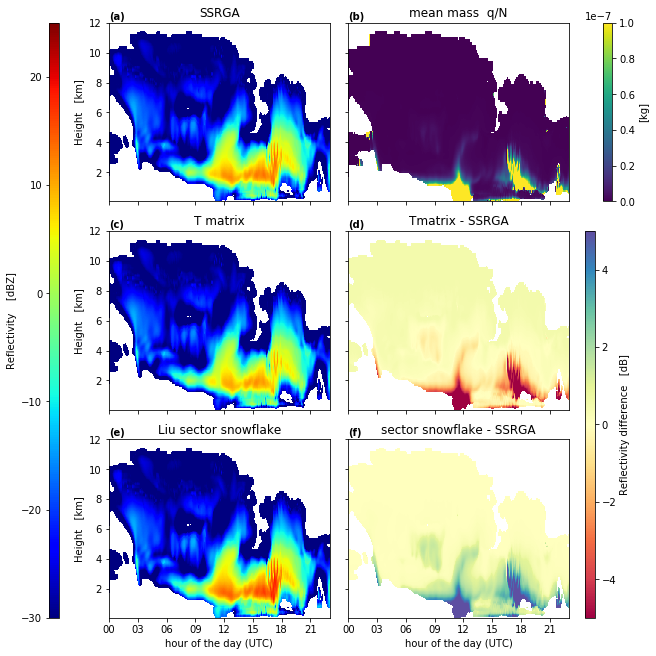

In [14]:
# PLOT FOR PAPER
plt.rcParams.update({'font.size':10})
freq = 'W'
grid = True
fig, axs = plt.subplots(3, 2, figsize=(9, 9), sharex=True, sharey=True, constrained_layout=True)
mesh = axs[0, 0].pcolormesh(data.time, data.height*1.0e-3, data.Zssrga.loc[dict(frequency=freq)].T, vmin=-30, vmax=25, cmap='jet', rasterized=True)
axs[0, 0].set_title('SSRGA')
mesh = axs[1, 0].pcolormesh(data.time, data.height*1.0e-3, data.Ztm.loc[dict(frequency=freq)].T, vmin=-30, vmax=25, cmap='jet', rasterized=True)
axs[1, 0].set_title('T matrix')
mesh = axs[2, 0].pcolormesh(data.time, data.height*1.0e-3, data.Zliu09.loc[dict(frequency=freq)].T, vmin=-30, vmax=25, cmap='jet', rasterized=True)
axs[2, 0].set_title('Liu sector snowflake')
fig.colorbar(mesh, ax=axs[:, 0], label='Reflectivity    [dBZ]', location='left', aspect=60, use_gridspec=grid)


mesh = axs[1, 1].pcolormesh(data.time, data.height*1.0e-3, data.Ztm.loc[dict(frequency=freq)].T-data.Zssrga.loc[dict(frequency=freq)].T, 
                            vmin=-5, vmax=5, cmap='Spectral', rasterized=True)
axs[1, 1].set_title('Tmatrix - SSRGA')
mesh = axs[2, 1].pcolormesh(data.time, data.height*1.0e-3, data.Zliu09.loc[dict(frequency=freq)].T-data.Zssrga.loc[dict(frequency=freq)].T, 
                            vmin=-5, vmax=5, cmap='Spectral', rasterized=True)
axs[2, 1].set_title('sector snowflake - SSRGA')
fig.colorbar(mesh, ax=axs[1:, 1], label='Reflectivity difference   [dB]', aspect=40, use_gridspec=grid)

mesh = axs[0, 1].pcolormesh(data.time, data.height*1.0e-3, 1.0e0*(iconP3data.qi.T/iconP3data.qni.T), vmax=1.0e-7, rasterized=True)
axs[0, 1].set_title('mean mass  q/N')
fig.colorbar(mesh, ax=[axs[0, 1]], label='[kg]', aspect=20, use_gridspec=grid)

[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
axs[0, 0].set_ylabel('Height   [km]')
axs[1, 0].set_ylabel('Height   [km]')
axs[2, 0].set_ylabel('Height   [km]')
axs[2, 0].set_xlabel('hour of the day (UTC)')
axs[2, 1].set_xlabel('hour of the day (UTC)')

for ax, l in zip(axs.flatten(), ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
    ax.text(0, 1.02, l,  fontweight='black', transform=ax.transAxes)

fig.savefig('comparison_Wband.png')
fig.savefig('comparison_Wband.pdf')